# Setup

In [1]:
import sys
sys.path.append('src')
import langevin_default
import codetimer as ct
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

---

# Langevin Impulse integrator

The Langevin Impulse (LI) integrator is the "SD" (stochastic dynamics) integrator used in GROMACS (and also GROMOS). It is an "impulsive Langevin" extension to the familiar leap-frog algorithm. Though the authors state at the outset that they seek an algorithm that is of the same order of accuracy as the Verlet-type algorithms, though it's not clear whether this stochastic algorithm is truly correct to second order in the timestep, $\mathcal{O}(\Delta t^2)$.

Primary reference: [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876)

See also: [R. D. Skeel & J. A. Izaguirre (2002), Mol. Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/0026897021000018321)

---

## Assumed dynamical form

The equation of motion is a second-order SDE of the Langevin type:

$$
\dot{x} = v(t)
$$
$$
\dot{v} = \frac{1}{m}F(x(t)) - \gamma\:\! v(t) + \xi(t),
$$
where $m$ is the particle mass, $\gamma = \zeta/m$ is the collision frequency, $\zeta$ is the usual friction coefficient, and the noise autocorrelation is given by

$$
\left\langle\xi(t)\xi(t')\right\rangle = \frac{2k_BT\gamma}{m}\delta(t-t').
$$

## Numerical discretization

The LI numerical algorithm can be written in four steps<sup>[1](#footnote1)</sup>:

$$v_\text{LF}^{n+1/2} = v^{n-1/2} + \Delta t\frac{F(x^n)}{m}$$

$$\Delta v = -\alpha\:\! v_\text{LF}^{n+1/2} + \sqrt{\alpha(2-\alpha)\frac{k_BT}{m}} \,\mathcal{W}^n$$

$$x^{n+1} = x^n + \Delta t\left(v_\text{LF}^{n+1/2} + \frac{1}{2}\Delta v\right)$$

$$v^{n+1/2} = v_\text{LF}^{n+1/2} + \Delta v$$

$$
\alpha = 1 - e^{-\gamma_\text{eff}\Delta t}
$$

where $\mathcal{W}^n$ is a zero-mean, unit variance white noise process sampled at each timestep, $n$. Note that $v_\text{LF}$ is the usual MD velocity update for the leap-frog scheme, $\gamma_\text{eff}$ is an _effective collision frequency_<sup>[2](#footnote2)</sup>, and $0 \leq \alpha \leq 1$ is a _velocity reduction factor_ that scales the impulsive application of friction and noise. Rewriting the above equations after substituting the definition of $\alpha$ and using $F(x^n) = F^n$, we have

$$v_\text{LF}^{n+1/2} = v^{n-1/2} + \Delta t\frac{F^n}{m}$$

$$\Delta v = -\left(1 - e^{-\gamma\Delta t}\right)v_\text{LF}^{n+1/2} + \sqrt{\left(1 - e^{-2\gamma\Delta t}\right)\frac{k_BT}{m}}\mathcal{W}^n$$

$$x^{n+1} = x^n + \Delta t\left(v_\text{LF}^{n+1/2} + \frac{1}{2}\Delta v\right)$$

$$v^{n+1/2} = v_\text{LF}^{n+1/2} + \Delta v$$

**Notes**:

<a name="footnote1">1</a>: For some reason, the [GROMACS manual](http://manual.gromacs.org/documentation/2018/manual-2018.pdf) specifies the noise term with $\sqrt{(1-\alpha^2)k_BT/m}$ rather than $\sqrt{\alpha(2-\alpha)k_BT/m}$ as specified in [N. Goga, et al. (2012), JCTC](https://pubs-acs-org.ezproxy1.lib.asu.edu/doi/10.1021/ct3000876). The GROMACS definition makes somewhat _less_ sense to me when considering the series expansion in powers of small $\gamma\Delta t$, though I'm not sure whether there's simply a typo in the manual or they're using a different definition.

<a name="footnote2">2</a>: From what I currently understand, $\gamma_\text{eff}$ is the collision frequency that results from discretizing the noise and friction in the system using $\alpha$. It makes sense, however, that when $\gamma\Delta t \ll 1$, we have $\alpha = \gamma\Delta t + \mathcal{O}(\Delta t^2)$ and $\alpha(2-\alpha) = 2\gamma\Delta t$, which leads to

$$
\Delta v = -\Delta t \:\!\gamma\:\! v_\text{LF}^{n+1/2} + \sqrt{\frac{2 \gamma\:\!k_BT\Delta t}{m}} \,\mathcal{W}^n
$$

---
## Test Langevin Impulse integration

In [2]:
li_sim = langevin_default.Langevin(outfile='data/LI_test', method='LI',
                            N=1, D=3, T=1, m=100.0, gamma=1.0, k=0.0, dt=1.0)

In [3]:
with ct.Timer(unit='secs') as t:
    li_sim.run(nsteps=100000, writeout=100000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 100000 (100.0% complete) – elapsed time: 1.5 s


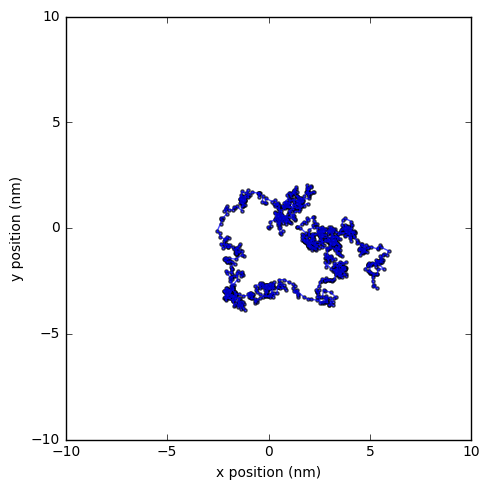

In [4]:
plt.clf()
fig, ax = li_sim.quick_plot(projection=None, start=0, end=None, skip=100,
                              xlim=[-10,10], ylim=[-10,10], zlim=[-10,10],
                              figsize=5.0, ptsize=5)

---

# Grønbech-Jensen–Farago integrator

This integrator is described by the authors as "a revision to the well known Störmer–Verlet algorithm for simulating second order differential equations. The revision addresses the inclusion of linear friction with associated stochastic noise, and we analytically demonstrate that the new algorithm correctly reproduces diffusive behavior of a particle in a flat potential." The algorithm is correct to second order in the timeste, $\mathcal{O}(\Delta t^2)$.

Reference: [N. Grønbech-Jensen  & O. Farago (2013). Mol.Phys.](http://www.tandfonline.com.ezproxy1.lib.asu.edu/doi/abs/10.1080/00268976.2012.760055)

---

## Assumed dynamical form

The equation of motion is a second-order SDE of the Langevin type:

$$
\dot{x} = v(t)
$$

$$
m\dot{v} = F(x(t)) - m\:\!\gamma\:\! v(t) + \beta(t),
$$

where $m$ is the particle mass, $\gamma = \zeta/m$ is the collision frequency, $\zeta$ is the usual friction coefficient, and the noise autocorrelation is given by

$$
\left\langle\beta(t)\beta(t')\right\rangle = 2m\:\!\gamma \:\!k_BT\:\!\delta(t-t').
$$

## Numerical discretization

First, we note that the autocorrelation is expressed in terms of the time step (just like in the first-order BBK algorithm),

$$
\left\langle\beta^n\beta^m\right\rangle = 2m\:\!\gamma \:\!k_BT\Delta t\:\!\delta_{nm},
$$

which will be used in the expressions that follow. The numerical algorithm is given by

$$
x^{n+1} = x^n + \alpha\Delta t\:\! v^n + \frac{ \alpha\Delta t^2}{2m}F(x^n) + \frac{\alpha\Delta t}{2m}\beta^{n+1}
$$

$$
v^{n+1} = v^n + \frac{\Delta t}{2m}\left[F\left(x^n\right) + F\left(x^{n+1}\right)\right] - \gamma\left(x^{n+1} - x^n\right) + \frac{1}{m}\beta^{n+1}
$$

$$
\alpha = \frac{1}{1 + \frac{\gamma\Delta t}{2}},
$$

where the timestep must be sufficiently small to satisfy $\gamma\Delta t < 2$. Using the substitution $F(x^n) = F^n$ along with $\beta^n = \sqrt{2m\:\!\gamma \:\!k_BT\Delta t}\:\! \mathcal{W}^n$, where $\mathcal{W}$ is a zero-mean, unit-variance white noise, we can rewrite the above discretization as

$$
\Delta x = \alpha\Delta t\left(v^n + \frac{\Delta t}{2m}F^n + \frac{1}{2}\sqrt{\frac{2\gamma\:\!k_BT \Delta t}{m}}\,\mathcal{W}^{n+1}\right)
$$

$$
x^{n+1} = x^n + \Delta x
$$

$$
v^{n+1} = v^n - \gamma\Delta x + \frac{\Delta t}{2m}\left(F^n + F^{n+1}\right) + \sqrt{\frac{2\gamma\:\!k_BT\Delta t}{m}}\,\mathcal{W}^{n+1}
$$

---
## Test Grønbech-Jensen–Farago integration

In [2]:
gjf_sim = langevin_default.Langevin(outfile='data/GJF_test', method='GJF',
                            N=1, D=3, T=1, m=100.0, gamma=1.0, k=0.0, dt=1.0)

In [3]:
with ct.Timer(unit='secs') as t:
    gjf_sim.run(nsteps=100000, writeout=100000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 100000 (100.0% complete) – elapsed time: 1.9 s


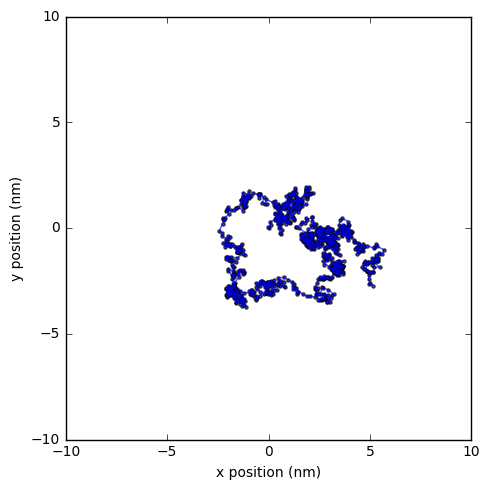

In [4]:
plt.clf()
fig, ax = gjf_sim.quick_plot(projection=None, start=0, end=None, skip=100,
                              xlim=[-10,10], ylim=[-10,10], zlim=[-10,10],
                              figsize=5.0, ptsize=5)

---

---

---

### T = 0 | N = 8

In [2]:
sim31_8_0 = md.MD(outfile='traj3-1_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim32_8_0 = md.MD(outfile='traj3-2_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim33_8_0 = md.MD(outfile='traj3-3_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=0.2)
sim34_8_0 = md.MD(outfile='traj3-4_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim35_8_0 = md.MD(outfile='traj3-5_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)
sim36_8_0 = md.MD(outfile='traj3-6_N8_T0.h5',N=8,T=0,f=7.5,zmax=5.0,dt=0.0025,initval=-0.2)

### T = 300 | N = 8

In [3]:
sim31_8_300 = md.MD(outfile='traj3-1_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim32_8_300 = md.MD(outfile='traj3-2_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim33_8_300 = md.MD(outfile='traj3-3_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=0.4)
sim34_8_300 = md.MD(outfile='traj3-4_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim35_8_300 = md.MD(outfile='traj3-5_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)
sim36_8_300 = md.MD(outfile='traj3-6_N8_T300.h5',N=8,T=300,f=7.5,zmax=5.0,dt=0.001,initval=-0.4)

## Run simulations

### T = 0 K , N = 8

# 0

In [4]:
with ct.Timer(unit='secs') as t:
    sim31_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_0.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 130000 (13.0% complete) – elapsed time: 13.4 s
Step 130000 (13.0% complete) – elapsed time: 15.9 s
Step 130000 (13.0% complete) – elapsed time: 14.4 s
Step 130000 (13.0% complete) – elapsed time: 14.6 s
Step 130000 (13.0% complete) – elapsed time: 15.6 s
Step 130000 (13.0% complete) – elapsed time: 16.2 s


### T = 300 K , N = 8

# 300

In [5]:
with ct.Timer(unit='secs') as t:
    sim31_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim32_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim33_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim34_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim35_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)
with ct.Timer(unit='secs') as t:
    sim36_8_300.run(steps=1000000, writeout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Step 420000 (42.0% complete) – elapsed time: 45.7 s
Step 230000 (23.0% complete) – elapsed time: 24.6 s
Step 540000 (54.0% complete) – elapsed time: 59.3 s
Step 430000 (43.0% complete) – elapsed time: 49.8 s
Step 340000 (34.0% complete) – elapsed time: 37.7 s
Step 680000 (68.0% complete) – elapsed time: 69.5 s


# Raw data

We can view the trajectory output directly. It's a pandas DataFrame stored persistently in HDF5 format.

# Plotting

## T = 0 K , N = 8

### XY plots

In [ ]:
s = 0
sim31_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='xy', start=s, end=None, skip=100)

### YZ plots

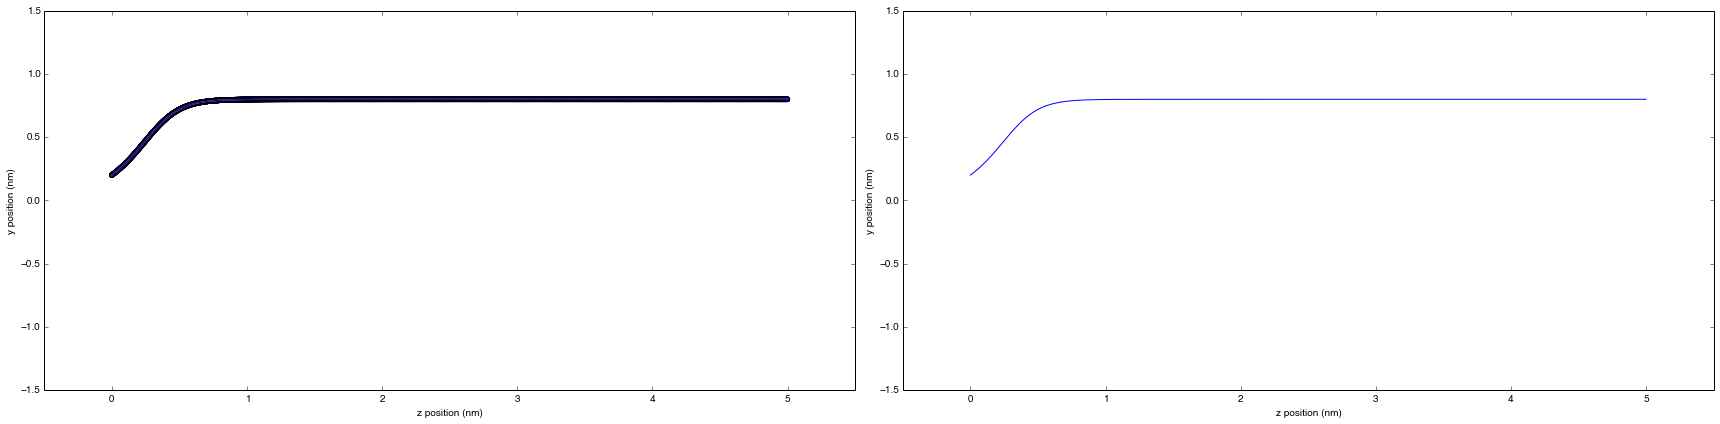

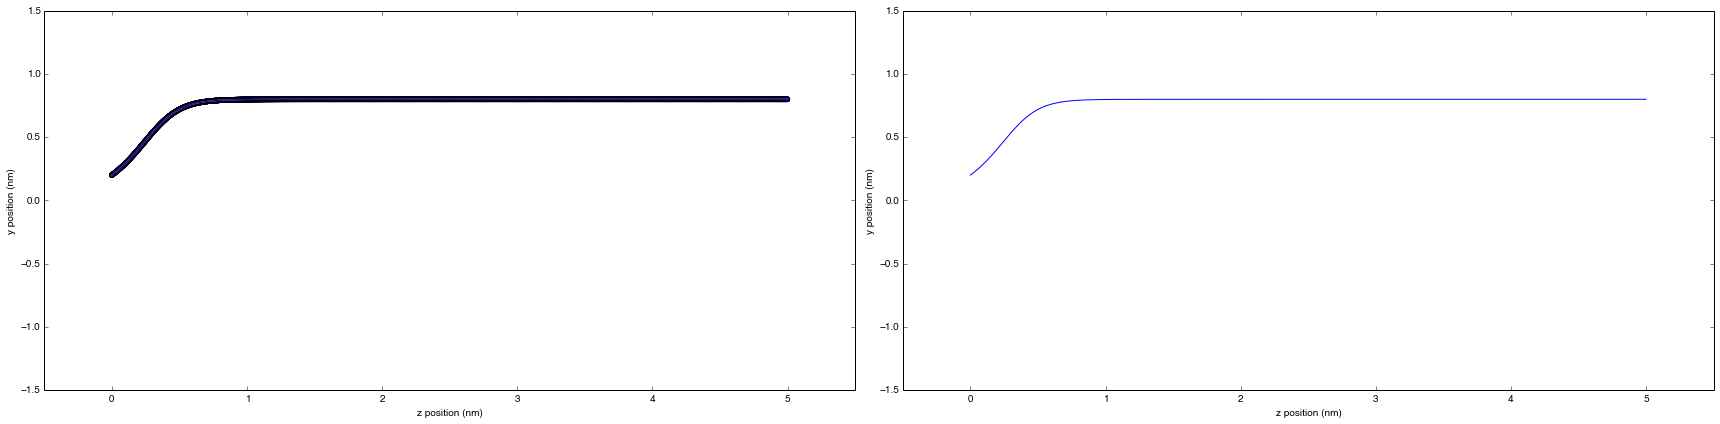

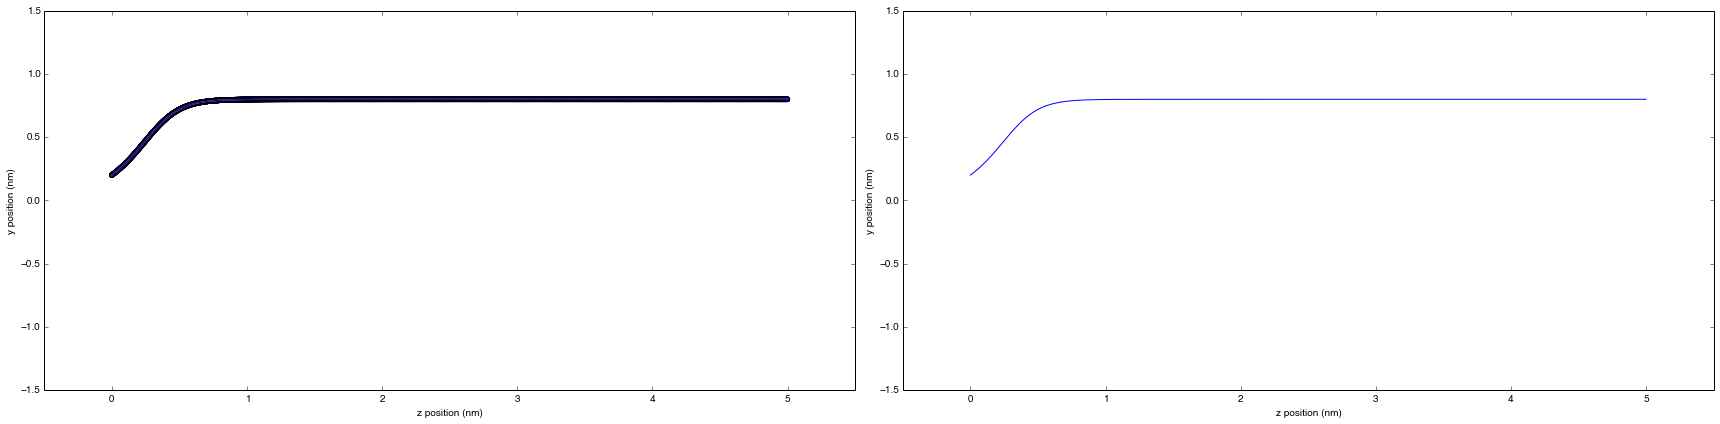

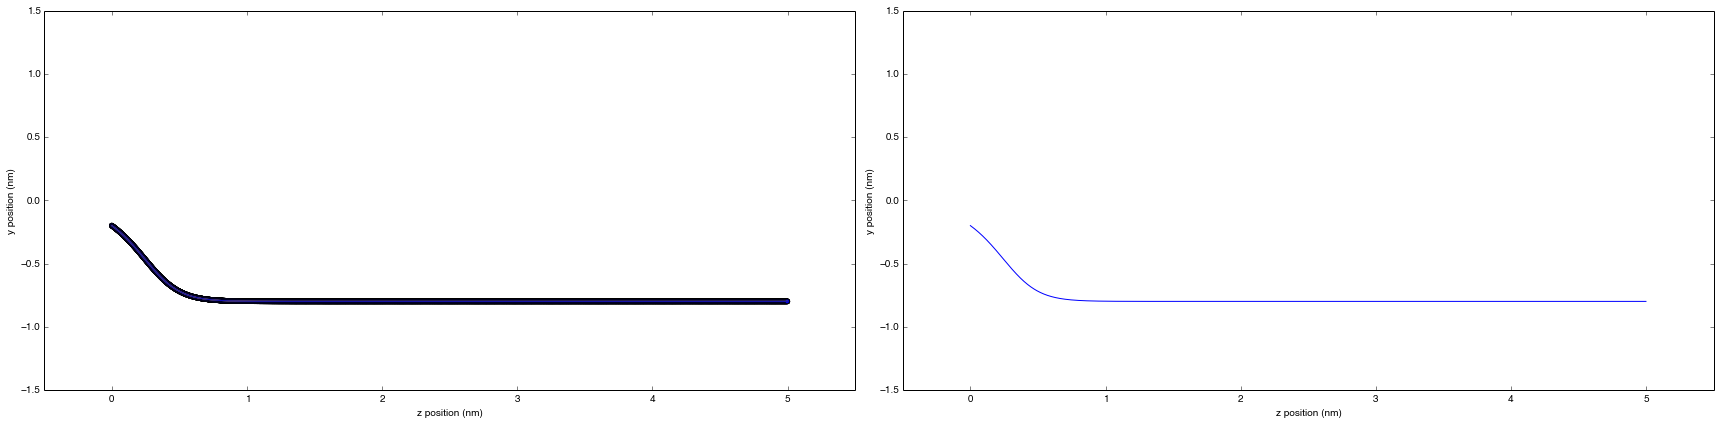

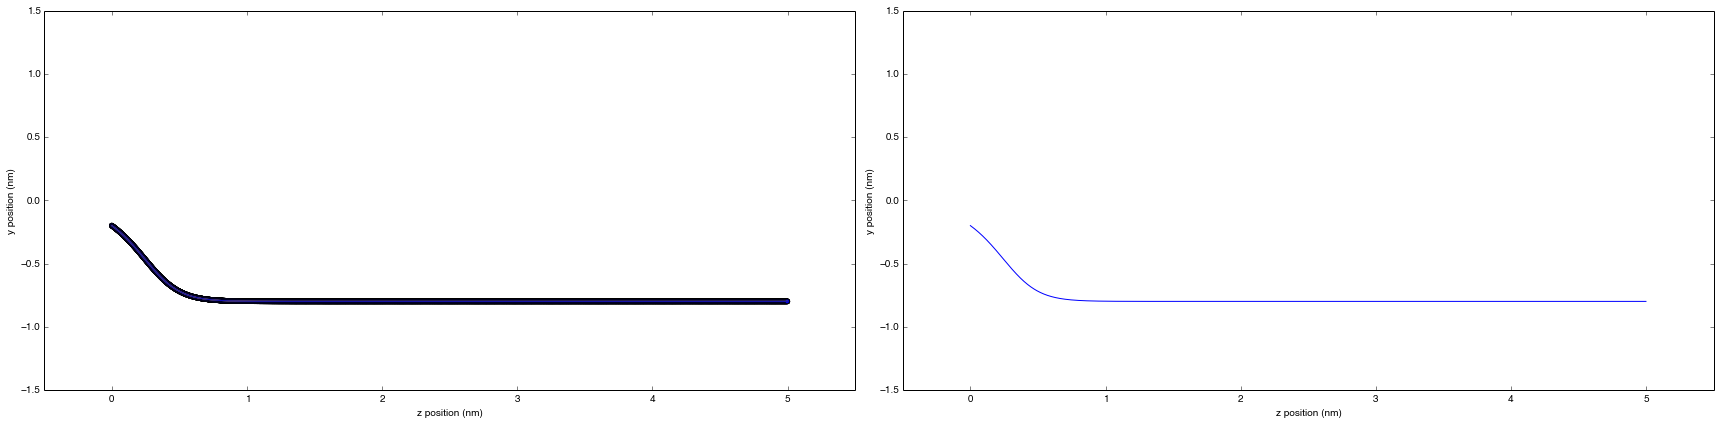

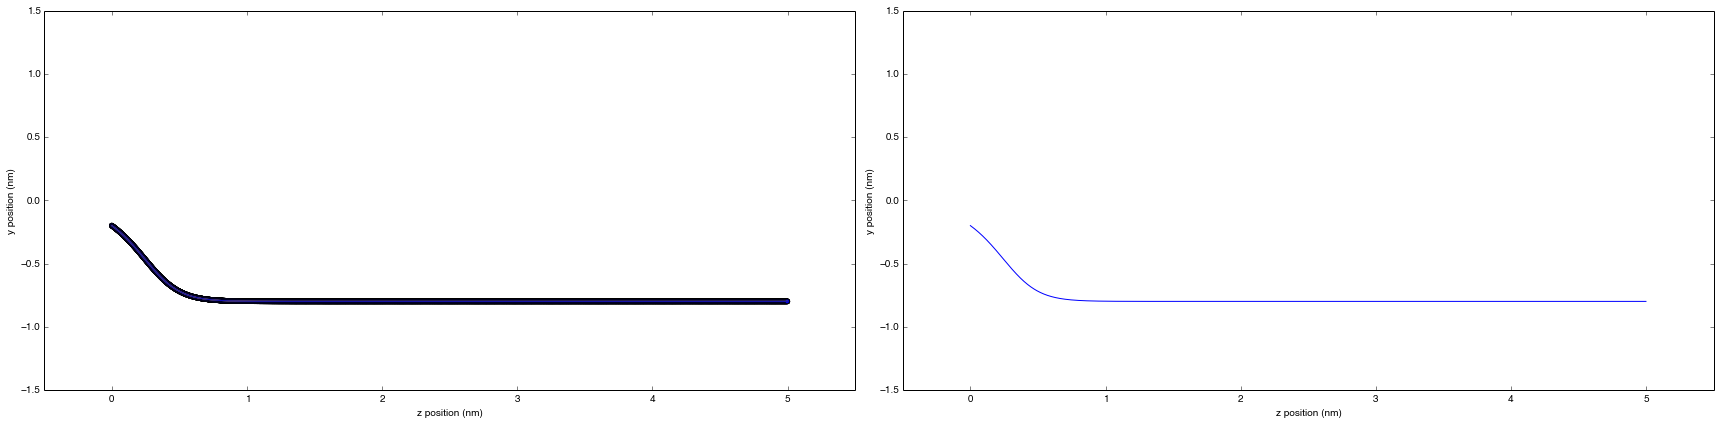

In [6]:
s = 0
sim31_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_0.plot_trajectories(projection='yz', start=s, end=None, skip=100)

## T = 300 K , N = 8

### XY plots

In [ ]:
sim.plot_trajectories(projection='xy', skip=1000)

### YZ plots

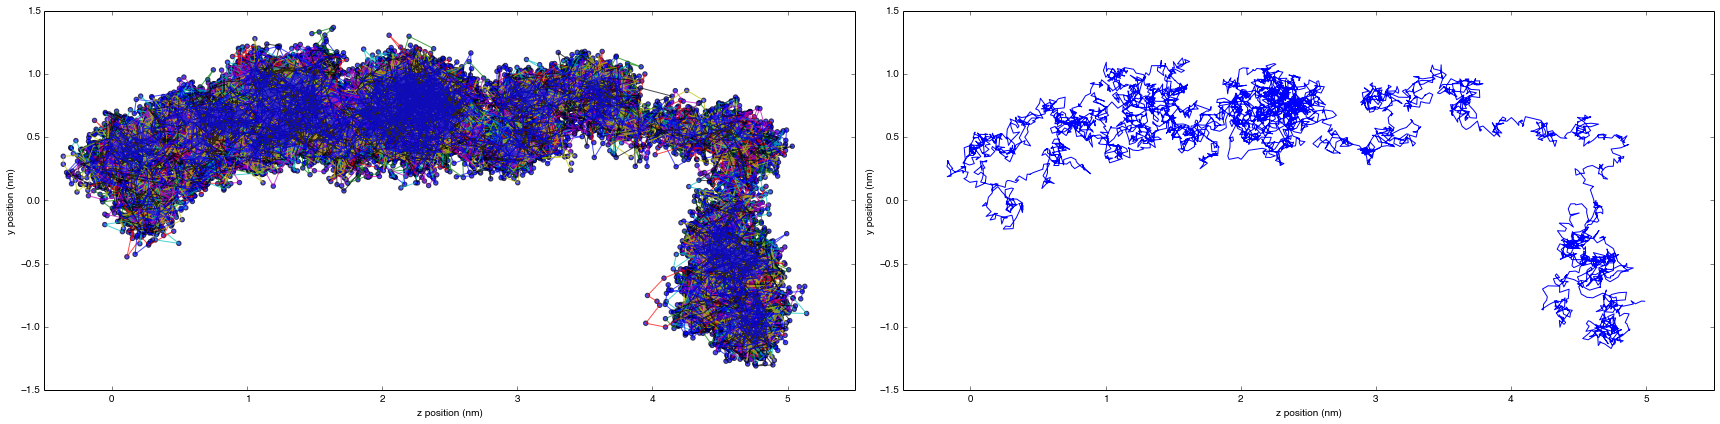

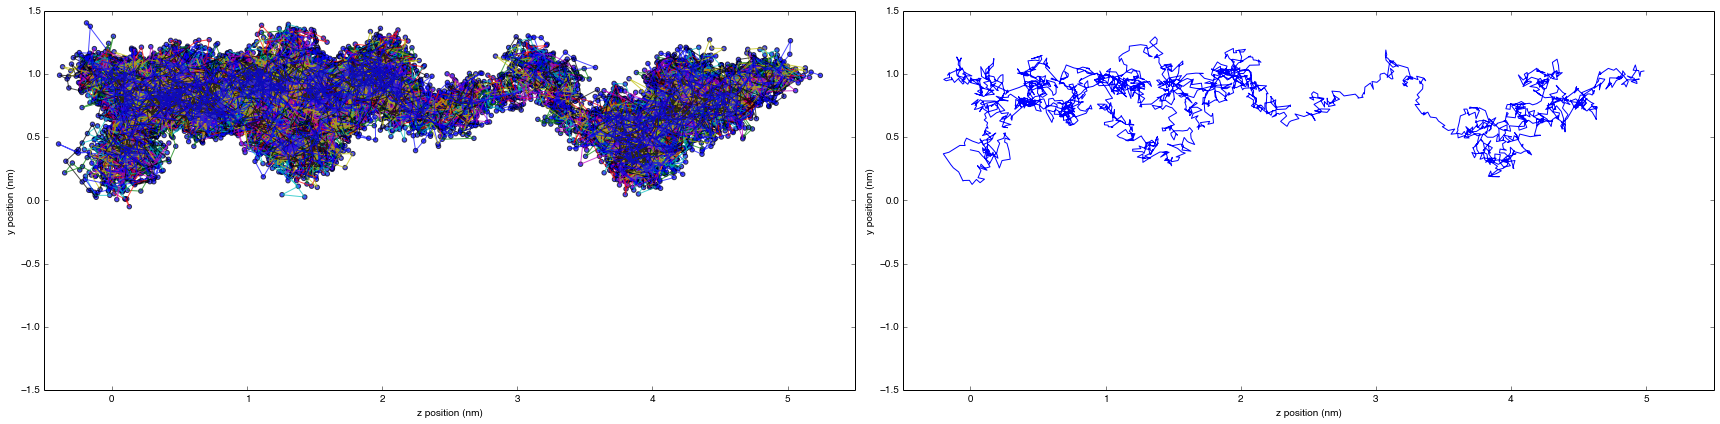

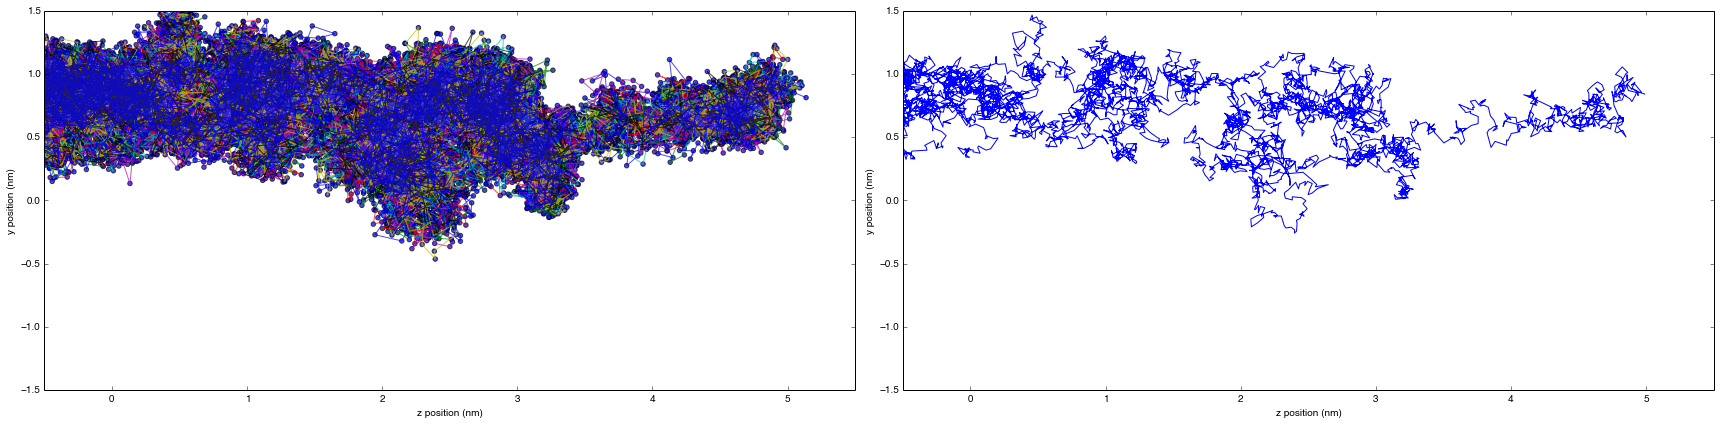

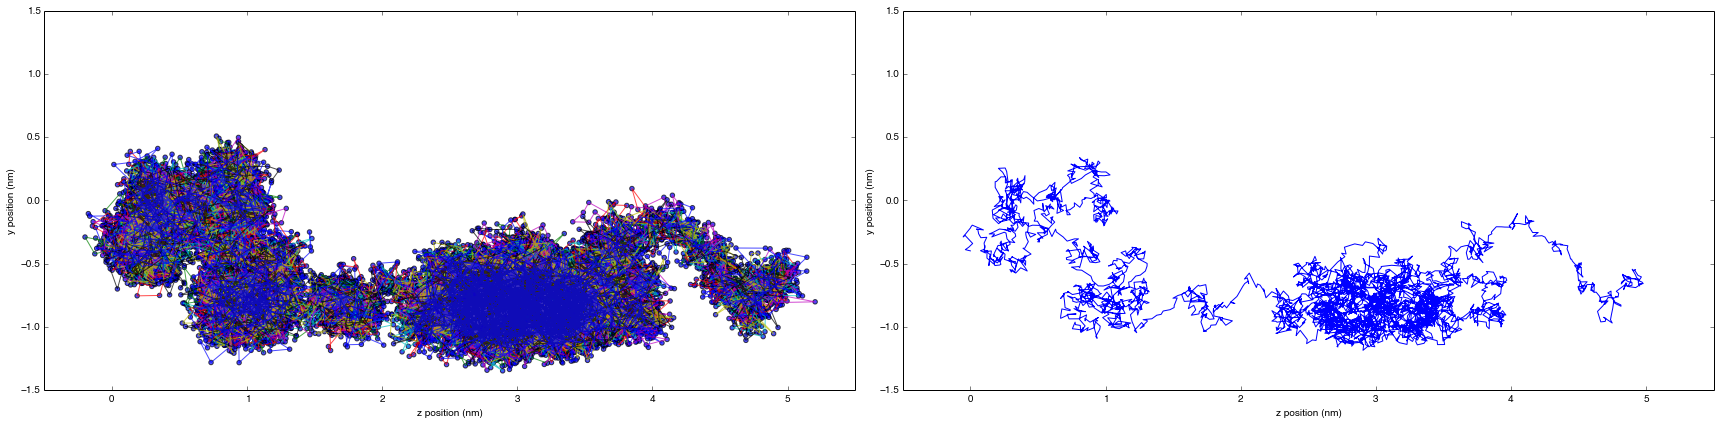

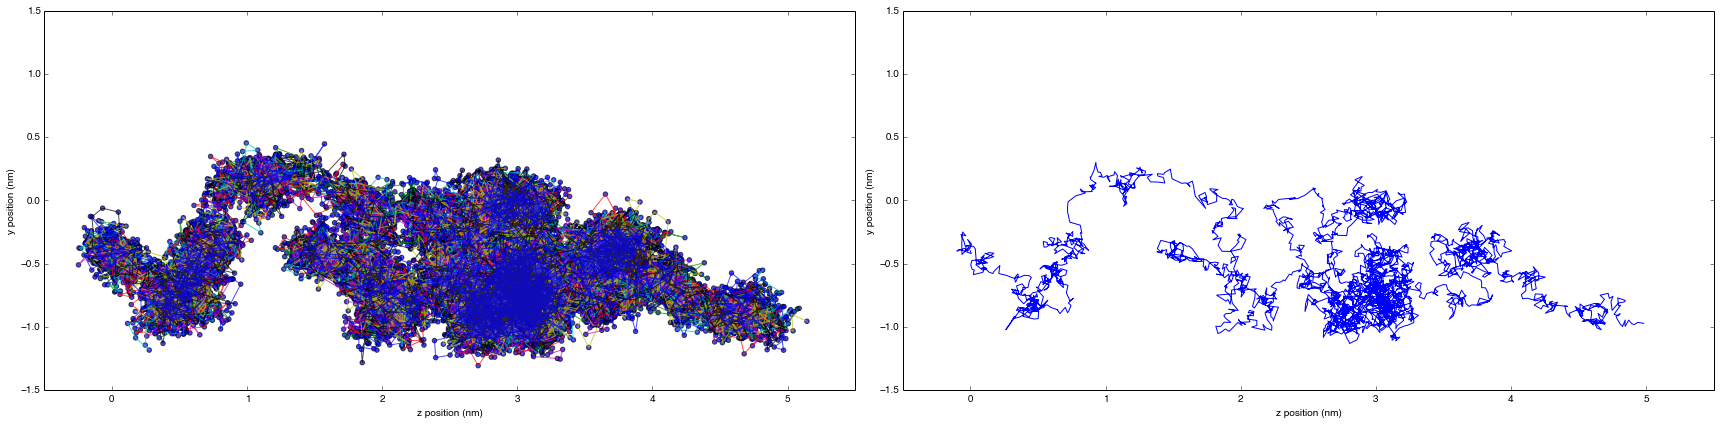

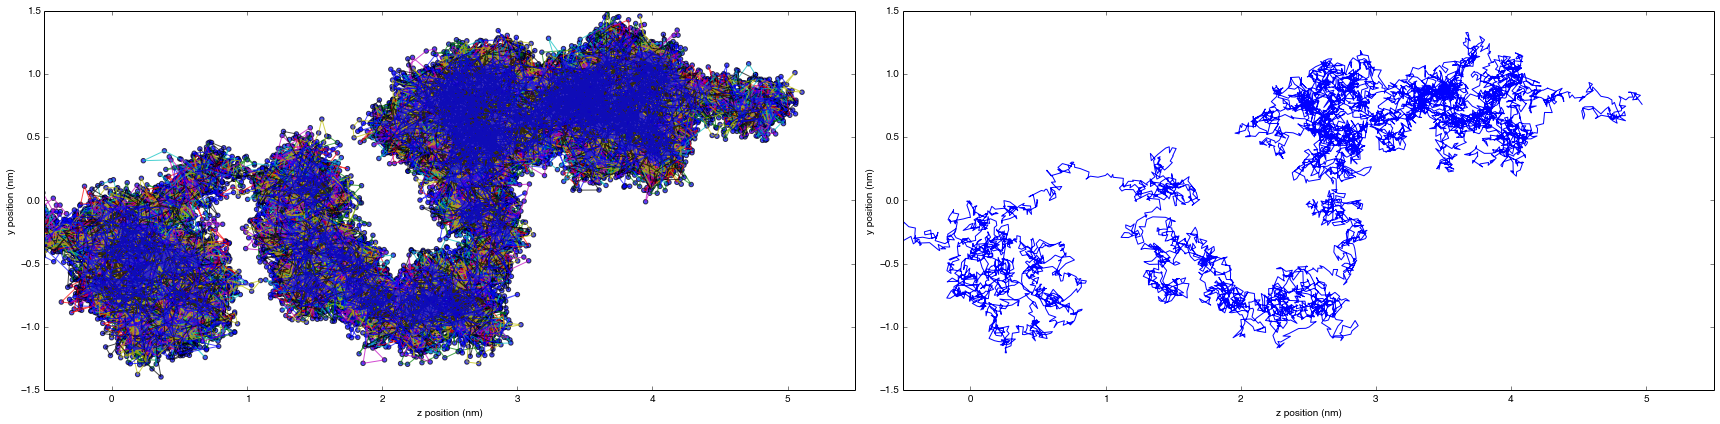

In [8]:
s=0
sim31_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim32_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim33_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim34_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim35_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)
sim36_8_300.plot_trajectories(projection='yz', start=s, end=None, skip=100)

In [68]:
simtest.compute_particle_size()

(array([ 0.22106883,  0.21892975,  0.21886752]),
 0.38040065270089218,
 0.21962203501782554,
 0.38961259711579105)

In [69]:
simtest2.compute_particle_size()

(array([ 0.22004685,  0.22021797,  0.22240095]),
 0.38259475816196803,
 0.22088858691080987,
 0.391798958433341)

In [10]:
sim31_8_0.compute_rog()

AttributeError: 'MD' object has no attribute 'compute_rog'